In [1]:
reset -sf

In [241]:
import sys
import os
import numpy as np 
import pandas as pd
from pathlib import Path

# univariate mlp example
from numpy import array

from keras import optimizers
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Conv1D, MaxPooling1D, Flatten, Dropout, \
                        GlobalMaxPooling1D, Input, add, GlobalAveragePooling1D
from keras import layers
from keras.models import Model

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.externals import joblib 
import matplotlib.pyplot as plt

In [3]:
PATH = Path("../../data/")

In [4]:
scaler = joblib.load(PATH/'train_scaler_x.pkl')

/home/administrador/anaconda3/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator StandardScaler from version 0.20.1 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [190]:
dfX_Train = np.load(PATH/'train_x.npy')
dfX_Val = np.load(PATH/'val_x.npy') 
dfX_Test = np.load(PATH/'test_x.npy')
dfY_Train = np.load(PATH/'train_y.npy')
dfY_Val = np.load(PATH/'val_y.npy')
dfY_Test = np.load(PATH/'test_y.npy')
print(dfX_Train.shape, dfY_Train.shape)
print(dfX_Val.shape, dfY_Val.shape)
print(dfX_Test.shape, dfY_Test.shape)
print(dfX_Train[0,:10])

(8126, 2500) (8126, 1250)
(1016, 2500) (1016, 1250)
(1016, 2500) (1016, 1250)
[1.0743 1.0802 1.1212 1.2092 1.35   1.5396 1.7664 2.0088 2.2473 2.4399]


In [191]:
history=None
freq = 125
ini = 0 #freq
dim = freq * 2
ecg = 1250

In [192]:
#Compute max, min
dfY_Train_sum = np.hstack((dfY_Train[:,ini:ini+dim].max(axis=1).reshape(-1,1), 
                           dfY_Train[:,ini:ini+dim].min(axis=1).reshape(-1,1), 
                           ))

dfY_Val_sum = np.hstack((dfY_Val[:,ini:ini+dim].max(axis=1).reshape(-1,1), 
                           dfY_Val[:,ini:ini+dim].min(axis=1).reshape(-1,1), 
                           ))

dfY_Test_sum = np.hstack((dfY_Test[:,ini:ini+dim].max(axis=1).reshape(-1,1), 
                           dfY_Test[:,ini:ini+dim].min(axis=1).reshape(-1,1), 
                           ))

print(dfY_Train_sum[0])
print(dfY_Val_sum[0])
print(dfY_Test_sum[0])

trainY_s = dfY_Train_sum
valY_s = dfY_Val_sum
testY_s = dfY_Test_sum

[134.32   69.749]
[167.73  69.31]
[135.93   70.531]


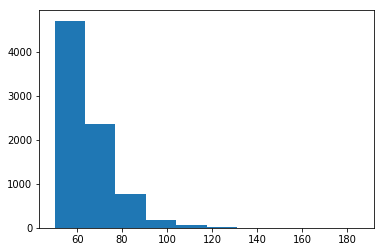

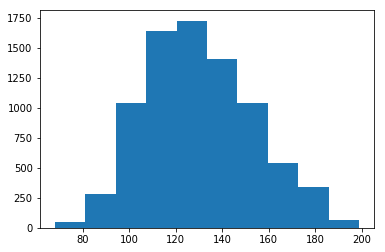

In [193]:
plt.hist(dfY_Train_sum[:,1])
plt.show()
plt.hist(dfY_Train_sum[:,0])
plt.show()

In [194]:
#Normalize Y
rng = (dfY_Train[:,ini:ini+dim].max(axis=1) - dfY_Train[:,ini:ini+dim].min(axis=1))
trainY_n = np.array([dfY_Train [:,i] - dfY_Train[:,ini:ini+dim].min(axis=1) 
                       for i in range(ini,ini+dim)]) / rng

rng = (dfY_Val[:,ini:ini+dim].max(axis=1) - dfY_Val[:,ini:ini+dim].min(axis=1))
valY_n = np.array([dfY_Val [:,i] - dfY_Val[:,ini:ini+dim].min(axis=1) 
                       for i in range(ini,ini+dim)]) / rng

rng = (dfY_Test[:,ini:ini+dim].max(axis=1) - dfY_Test[:,ini:ini+dim].min(axis=1))
testY_n = np.array([dfY_Test [:,i] - dfY_Test[:,ini:ini+dim].min(axis=1) 
                       for i in range(ini,ini+dim)]) / rng

trainY_n = trainY_n.T
valY_n = valY_n.T
testY_n = testY_n.T 

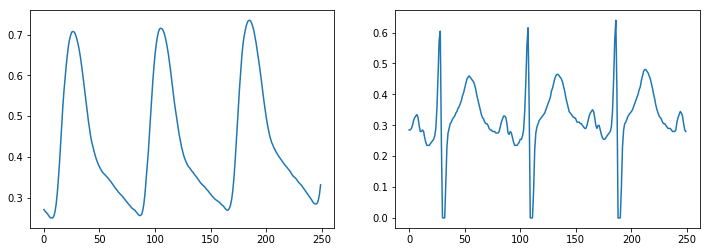

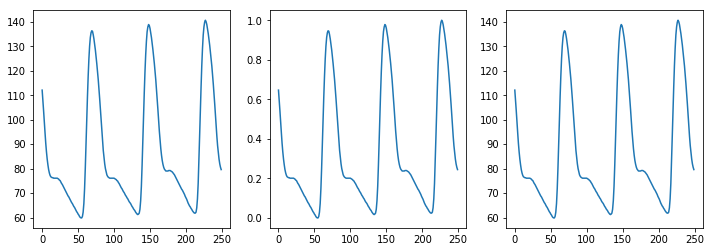

In [195]:
#Plotting X
ix = 15

plt.figure(figsize=(12,4))

#ppg
ax = plt.subplot(1,2,1)
ax.plot(dfX_Train[ix,:dim])

#ecg
ax = plt.subplot(1,2,2)
ax.plot(dfX_Train[ix,ecg:ecg + dim])

#Plotting Y
#real
plt.figure(figsize=(12,4))
ax = plt.subplot(1,3,1)
ax.plot(dfY_Train[ix,:dim])

#norm
ax = plt.subplot(1,3,2)
ax.plot(trainY_n[ix,:])

#denorm
ax = plt.subplot(1,3,3)
rng_0 = dfY_Train_sum[ix,0] - dfY_Train_sum[ix,1]
ax.plot((trainY_n[ix,:]*rng_0) + dfY_Train_sum[ix,1])
plt.show()

In [110]:
#Normalize X
rng = (dfX_Train[:,ini:ini+dim].max(axis=1) - dfX_Train[:,ini:ini+dim].min(axis=1))
trainX_0_n = np.array([dfX_Train [:,i] - dfX_Train[:,ini:ini+dim].min(axis=1) 
                       for i in range(ini,ini+dim)]) / rng

rng = (dfX_Train[:,ecg+ini:ini+ecg+dim].max(axis=1) - dfX_Train[:,ecg+ini:ini+ecg+dim].min(axis=1))
trainX_1_n = np.array([dfX_Train [:,i] - dfX_Train[:,ini+ecg:ini+ecg+dim].min(axis=1) for i in range(ini+ecg,ini+ecg+dim)]) / rng

rng = (dfX_Val[:,ini:ini+dim].max(axis=1) - dfX_Val[:,ini:ini+dim].min(axis=1))
valX_0_n = np.array([dfX_Val [:,i] - dfX_Val[:,ini:ini+dim].min(axis=1) 
                       for i in range(ini,ini+dim)]) / rng

rng = (dfX_Val[:,ecg+ini:ini+ecg+dim].max(axis=1) - dfX_Val[:,ecg+ini:ini+ecg+dim].min(axis=1))
valX_1_n = np.array([dfX_Val [:,i] - dfX_Val[:,ini+ecg:ini+ecg+dim].min(axis=1) for i in range(ini+ecg,ini+ecg+dim)]) / rng

rng = (dfX_Test[:,ini:ini+dim].max(axis=1) - dfX_Test[:,ini:ini+dim].min(axis=1))
testX_0_n = np.array([dfX_Test [:,i] - dfX_Test[:,ini:ini+dim].min(axis=1) 
                       for i in range(ini,ini+dim)]) / rng

rng = (dfX_Test[:,ecg+ini:ini+ecg+dim].max(axis=1) - dfX_Test[:,ecg+ini:ini+ecg+dim].min(axis=1))
testX_1_n = np.array([dfX_Test [:,i] - dfX_Test[:,ini+ecg:ini+ecg+dim].min(axis=1) for i in range(ini+ecg,ini+ecg+dim)]) / rng

trainX_0_n = trainX_0_n.T
trainX_1_n = trainX_1_n.T
valX_0_n = valX_0_n.T
valX_1_n = valX_1_n.T
testX_0_n = testX_0_n.T 
testX_1_n = testX_1_n.T

print(trainX_0_n.shape,trainX_1_n.shape)
print(valX_0_n.shape,valX_1_n.shape)
print(testX_0_n.shape,testX_1_n.shape)

(8126, 250) (8126, 250)
(1016, 250) (1016, 250)
(1016, 250) (1016, 250)


In [ ]:
#Do not scale (0-1)

In [197]:
trainX_0_n = dfX_Train [:,ini:ini+dim]
trainX_1_n = dfX_Train [:,ini+ecg:ini+ecg+dim]

valX_0_n =dfX_Val [:,ini:ini+dim]
valX_1_n = dfX_Val[:,ecg+ini:ini+ecg+dim]

testX_0_n = dfX_Test[:,ini:ini+dim]
testX_1_n = dfX_Test[:,ecg+ini:ini+ecg+dim]

trainX_n = np.stack((trainX_0_n, trainX_1_n), axis=2)
valX_n = np.stack((valX_0_n,valX_1_n), axis=2)
testX_n = np.stack((testX_0_n, testX_1_n), axis=2)

print(trainX_n.max(), trainX_n.min(), trainX_n.std())
print(trainX_n.shape, valX_n.shape, testX_n.shape, trainY_n.shape, valY_n.shape, testY_n.shape)

4.5 -3.498 0.8156937694160916
(8126, 250, 2) (1016, 250, 2) (1016, 250, 2) (8126, 250) (1016, 250) (1016, 250)


In [ ]:
#Standarize

In [198]:
scaler_ppg = StandardScaler().fit(trainX_n[:,:,0])
scaler_ecg = StandardScaler().fit(trainX_n[:,:,1])
print(scaler_ppg.mean_.shape)
print(scaler_ecg.mean_.shape)

(250,)
(250,)


In [199]:
trainX_n = np.stack((scaler_ppg.transform(trainX_n[:,:,0]).reshape(-1,250), scaler_ecg.transform(trainX_n[:,:,1]).reshape(-1,250)), axis=2)
valX_n = np.stack((scaler_ppg.transform(valX_n[:,:,0]).reshape(-1,250), scaler_ecg.transform(valX_n[:,:,1]).reshape(-1,250)), axis=2)
testX_n = np.stack((scaler_ppg.transform(testX_n[:,:,0]).reshape(-1,250), scaler_ecg.transform(testX_n[:,:,1]).reshape(-1,250)), axis=2)

print(trainX_n.max(), trainX_n.min(), trainX_n.std())
print(trainX_n.shape, valX_n.shape, testX_n.shape, trainY_n.shape, valY_n.shape, testY_n.shape)

12.232114683629453 -11.461019164899536 1.0000000000000004
(8126, 250, 2) (1016, 250, 2) (1016, 250, 2) (8126, 250) (1016, 250) (1016, 250)


In [10]:
#Definition of the model

In [374]:
input_tensor = Input(shape=(dim, 2))

x = Conv1D(filters=96, kernel_size=64, activation='relu')(input_tensor)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.3)(x)

"""
x = Conv1D(filters=96, kernel_size=33, activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=3)(x)
x = Dropout(0.3)(x)
"""

x = GlobalMaxPooling1D()(x)

#Very important!!!
x = BatchNormalization()(x)
x = Dense(2)(x)

model = Model(input_tensor,x)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_125 (InputLayer)       (None, 250, 2)            0         
_________________________________________________________________
conv1d_238 (Conv1D)          (None, 187, 96)           12384     
_________________________________________________________________
batch_normalization_360 (Bat (None, 187, 96)           384       
_________________________________________________________________
max_pooling1d_203 (MaxPoolin (None, 93, 96)            0         
_________________________________________________________________
dropout_272 (Dropout)        (None, 93, 96)            0         
_________________________________________________________________
global_max_pooling1d_87 (Glo (None, 96)                0         
_________________________________________________________________
batch_normalization_361 (Bat (None, 96)                384       
__________

In [390]:
# fit model
model.compile(optimizer=optimizers.Adam(lr=1e-4), loss='mae')
history_prev = history

print(trainX_n.shape, valX_n.shape)

history = model.fit(trainX_n, trainY_s, validation_data=(valX_n, valY_s), batch_size=64, epochs=10, verbose=1)

(8126, 250, 2) (1016, 250, 2)
Train on 8126 samples, validate on 1016 samples
Epoch 1/10
8126/8126 [==============================] - 14s 2ms/step - loss: 10.0346 - val_loss: 12.9917
Epoch 2/10
8126/8126 [==============================] - 1s 161us/step - loss: 10.0553 - val_loss: 13.0053
Epoch 3/10
8126/8126 [==============================] - 1s 161us/step - loss: 10.0324 - val_loss: 12.9518
Epoch 4/10
8126/8126 [==============================] - 1s 160us/step - loss: 10.0106 - val_loss: 12.9560
Epoch 5/10
8126/8126 [==============================] - 1s 161us/step - loss: 10.0064 - val_loss: 13.0694
Epoch 6/10
8126/8126 [==============================] - 1s 160us/step - loss: 10.0227 - val_loss: 12.9683
Epoch 7/10
8126/8126 [==============================] - 1s 161us/step - loss: 10.0181 - val_loss: 13.0464
Epoch 8/10
8126/8126 [==============================] - 1s 161us/step - loss: 9.9913 - val_loss: 12.9542
Epoch 9/10
8126/8126 [==============================] - 1s 160us/step - loss

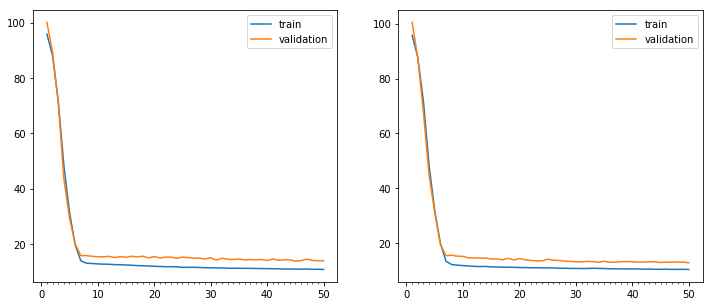

In [377]:
plt.figure(figsize=(12,5))
for i in range(2):
    if i == 0:
        if history_prev is None:
            continue
        else:
            hist = history_prev
    else:
        hist = history
        
    loss = hist.history["loss"]
    val_loss = hist.history["val_loss"]
    epochs = range(1, len(loss) +1)
    ax = plt.subplot(1,2,1+i)
    ax.plot(epochs, loss, label="train")
    ax.plot(epochs, val_loss, label="validation")
    ax.set_xticks(epochs, epochs)
    #ax.set_ylim(0.0,1.0)
    ax.legend()

plt.show()

In [ ]:
# Save the weights and architecture

In [394]:
model.save_weights('conv1d_hm.h5')
with open('conv1d_hm.json', 'w') as f:
    f.write(model.to_json())

In [11]:
model.load_weights('conv1d.h5')

In [ ]:
# Hard mining

In [386]:
y_pred = []
for ix in range(trainX_n.shape[0]):
    y_pred.append(model.predict([np.expand_dims(trainX_n[ix,:].reshape(250,2),0)]))
    
y_pred = np.hstack((np.arange(len(y_pred)).reshape(-1,1),np.array(y_pred).reshape(-1,2)))
print(y_pred.shape)

(8126, 3)


[[  0.         133.89030457  65.97103119]
 [  1.         136.83840942  67.213974  ]
 [  2.         136.23376465  68.13741302]
 [  3.         142.76098633  68.22229004]
 [  4.         143.35992432  69.96124268]
 [  5.         136.83892822  66.70146179]
 [  6.         136.60510254  67.46011353]
 [  7.         129.75762939  65.75640869]
 [  8.         127.6605835   63.67388153]
 [  9.         126.67337036  63.70051575]]
[[134.32   69.749]
 [118.11   57.587]
 [126.7    70.482]
 [139.55   65.256]
 [144.58   68.089]
 [151.61   69.994]
 [141.79   61.788]
 [147.26   70.873]
 [126.07   65.549]
 [125.63   64.865]]
Num selected hard cases: (423, 4)


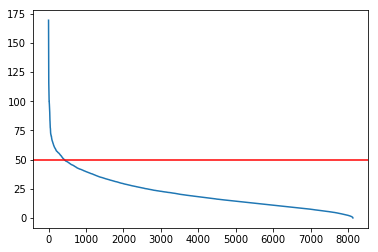

In [387]:
print(y_pred[:10,:])
print(trainY_s[:10,:])

diff = (y_pred[:,1:] - trainY_s)
diff = np.hstack((y_pred[:,0].reshape(-1,1), diff.reshape(-1,2), np.sum(np.abs(diff), axis=1).reshape(-1,1)))
dfDiff = pd.DataFrame(diff, columns=["id","min","max","all"])
dfDiff.sort_values("all", ascending=False, inplace=True)
selCases = dfDiff[dfDiff["all"]>50]["id"]
print("Num selected hard cases:", dfDiff[dfDiff["all"]>50].shape)

plt.plot(dfDiff["all"].values)
plt.axhline(50, c="r")
plt.show()

In [388]:
model.compile(optimizer=optimizers.Adam(lr=1e-4), loss='mae')
model.fit(trainX_n[selCases.values.astype(int),:], trainY_s[selCases.values.astype(int),:], 
          validation_data=(valX_n, valY_s), batch_size=8, epochs=10, verbose=1)

Train on 423 samples, validate on 1016 samples
Epoch 1/10
423/423 [==============================] - 14s 33ms/step - loss: 31.7204 - val_loss: 13.9295
Epoch 2/10
423/423 [==============================] - 1s 2ms/step - loss: 29.6353 - val_loss: 15.1946
Epoch 3/10
423/423 [==============================] - 1s 2ms/step - loss: 29.1804 - val_loss: 15.6367
Epoch 4/10
423/423 [==============================] - 1s 2ms/step - loss: 29.2324 - val_loss: 15.1725
Epoch 5/10
423/423 [==============================] - 1s 2ms/step - loss: 28.2535 - val_loss: 15.2296
Epoch 6/10
423/423 [==============================] - 1s 2ms/step - loss: 28.1246 - val_loss: 15.1221
Epoch 7/10
423/423 [==============================] - 1s 2ms/step - loss: 27.3680 - val_loss: 14.9895
Epoch 8/10
423/423 [==============================] - 1s 2ms/step - loss: 26.6621 - val_loss: 14.9092
Epoch 9/10
423/423 [==============================] - 1s 2ms/step - loss: 26.8507 - val_loss: 14.7364
Epoch 10/10
423/423 [============

In [ ]:
#Evaluation

In [391]:
y_pred = []
for ix in range(testX_n.shape[0]):
    y_pred.append(model.predict([np.expand_dims(testX_n[ix,:].reshape(250,2),0)]))

In [392]:
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score

y_pred = np.array(y_pred).reshape(-1,2)
print(y_pred.shape, testY_s.shape)
print("Test error analysis:")
print("Explained variance score:", explained_variance_score(testY_s, y_pred))
print("MAE error:", mean_absolute_error(testY_s, y_pred))
print("MSE error:", mean_squared_error(testY_s, y_pred))
print("R2 score:", r2_score(testY_s, y_pred))

(1016, 2) (1016, 2)
Test error analysis:
Explained variance score: 0.04916533008143864
MAE error: 12.89806072481409
MSE error: 302.5174696478981
R2 score: 0.020633056686991114


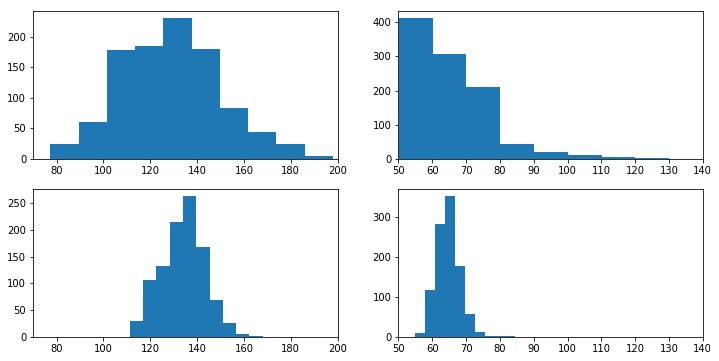

In [393]:
plt.figure(figsize=(12,6))
ax = plt.subplot(2,2,1)
ax.hist(testY_s[:,0])
ax.set_xlim((70,200))

ax = plt.subplot(2,2,2)
ax.hist(testY_s[:,1])
ax.set_xlim((50,140))

ax = plt.subplot(2,2,3)
ax.hist(y_pred[:,0])
ax.set_xlim((70,200))

ax = plt.subplot(2,2,4)
ax.hist(y_pred[:,1])
ax.set_xlim((50,140))
plt.show()

In [54]:
# Visualize

(1, 250, 2)


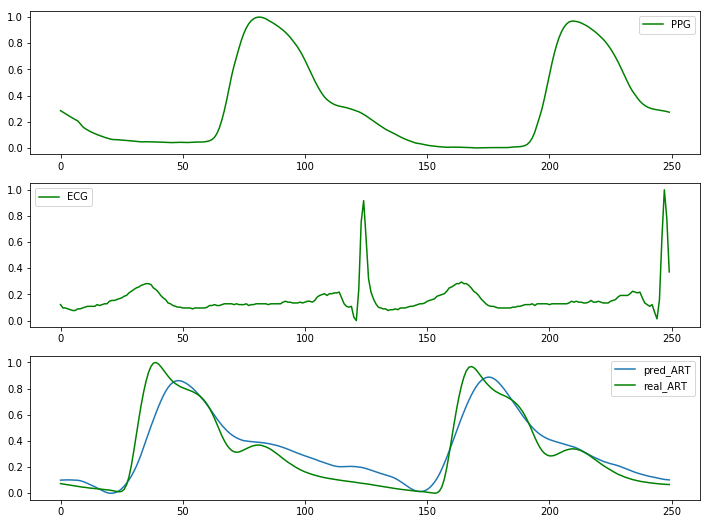

In [15]:
ix=10
print(np.expand_dims(testX_n[ix,:], axis=0).shape)

plt.figure(figsize=(12,9))
ax = plt.subplot(3,1,1)
ax.plot(testX_0_n[ix,:].reshape(1,-1).T, c="g", label="PPG")
ax.legend()

ax = plt.subplot(3,1,2)
ax.plot(testX_1_n[ix,:].reshape(1,-1).T, c="g", label="ECG")
plt.legend()


ax = plt.subplot(3,1,3)
ax.plot(model.predict(np.expand_dims(testX_n[ix,:], axis=0)).T, label="pred_ART")
ax.plot(testY_n[ix,:].reshape(1,-1).T, c="g", label="real_ART")
ax.legend()

plt.show()